# Implement Early Stopping

In [1]:
from custompackage.load_data import *
from custompackage.load_architecture import *
from custompackage.traintestloop import *


import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
import torchvision
from torchvision import transforms
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib
import matplotlib.pyplot as plt
from torch.optim.optimizer import required
from torch.utils.data.dataset import random_split
import scipy
import os
import glob
import pandas as pd
from hyperopt import hp, tpe, fmin, Trials
import pickle
from pytorchtools import EarlyStopping

% matplotlib inline

In [13]:
def train_test_fc(model, trainloader, validloader, testloader, epochs=10, patience=60):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    
    loss_curve = []
    acc_curve = []
    
    early_stopping = EarlyStopping(patience=patience, verbose=False)
        
        
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().reshape(-1,1))
            loss.backward()
            
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_acc += (torch.round(outputs) == labels.float().reshape(-1,1)).sum().item()/trainloader.batch_size
            if i % 4 == 3:    # print every 80 mini-batches
                loss_curve.append(running_loss/3)
                acc_curve.append(running_acc/3)
                running_loss = 0.0
                running_acc = 0.0
            
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for _, data in enumerate(validloader):
            inputs, labels, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, labels.float().reshape(-1,1))
            # record validation loss
            valid_losses.append(loss.item())
                
        valid_loss = np.average(valid_losses)


        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    print('Finished Training, %d epochs' % (epoch+1))
    
    correct = 0
    all_loss = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels.float().reshape(-1,1))
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.float().reshape(-1,1)).sum().item()
            all_loss += loss
    accuracy = correct/total
    ave_loss = all_loss.item()/total
    
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * accuracy))
        
    return(loss_curve, acc_curve, ave_loss, accuracy, model)

In [18]:
# Test space for networks
# Select Class Set
class_set = 3

# Initialize settings
bs = 256
weighting = 'paired'
trials = 10
epochs = 2000
trees_set = [1,2,4,8,16,32]
# trees_set = [8]


classes = np.load('./results/20200511/classes.npy', allow_pickle=True)

# if class_set == 0:
#     classes = classes[0:2] # mnist fmnist
# elif class_set == 1:
#     classes = classes[2:4] # kmnist emnist
# elif class_set == 2:
#     classes = classes[4:6] # svhn usps
# else:
#     classes = classes[6].reshape(1,-1)


loss = np.zeros((len(classes), trials, len(trees_set)))
acc = np.zeros((len(classes), trials, len(trees_set)))

    
for j, (t1, t2, ds) in enumerate(classes):
    print(t1, t2, ds)
    trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds, permute=False)
    input_size = trainloaders[0].dataset.tensors[0][0].shape[0]
    for i in range(trials):
        for k, trees in enumerate(trees_set):
            print(j, i, k)
#             model = ktree_gen(ds=ds, Repeats=trees, Padded=False).cuda()
            model = simple_fcnn(input_size, 2*trees, 1).cuda()
            
#             loss_curve, acc_curve, loss[j,i,k], acc[j,i,k], model_t = train_test_ktree(model, trainloaders[i],
#                                                                                   testloader, epochs = epochs, randorder=False)
            loss_curve, acc_curve, loss[j,i], acc[j,i], model_t = train_test_fc(model, trainloaders[i],
                                              validloaders[i], testloader, epochs=epochs)

            break
        break
    break
    
#             np.save('./results/20200504/k_tree_acc_'+str(class_set)+'.npy', acc)
#             np.save('./results/20200504/k_tree_loss_'+str(class_set)+'.npy', loss)


3 5 mnist
0 6 fmnist
2 6 kmnist
14 17 emnist
5 6 svhn
3 5 usps
3 5 cifar10


[0.00592762]


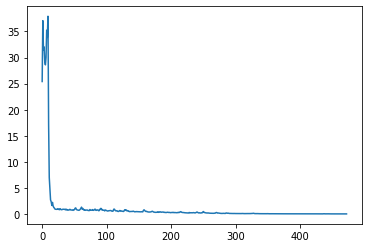

In [17]:
print(loss[0,0,])
plt.plot(loss_curve)

In [8]:
def train_test_ktree(model, trainloader, validloader, testloader, epochs=10, randorder=False, patience=30):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_curve = []
    acc_curve = []
    
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    if randorder == True:
        ordering = torch.randperm(len(trainloader.dataset.tensors[0][0]))
    
    early_stopping = EarlyStopping(patience=patience, verbose=False)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, _ = data
            if randorder == True:
                inputs = inputs[:,ordering].cuda()
            else:
                inputs = inputs.cuda()

            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().reshape(-1,1))
            loss.backward()
            
####        # Freeze select weights by zeroing out gradients
            for child in model.children():
                for param in child.parameters():
                    for freeze_mask in model.freeze_mask_set:
                        if param.grad.shape == freeze_mask.shape:
                            param.grad[freeze_mask] = 0
            
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_acc += (torch.round(outputs) == labels.float().reshape(-1,1)).sum().item()/trainloader.batch_size
            if (i % 4) == 3:    # print every 80 mini-batches
                loss_curve.append(running_loss/3)
                acc_curve.append(running_acc/3)
                running_loss = 0.0
        
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for _, data in enumerate(validloader):
            inputs, labels, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, labels.float().reshape(-1,1))
            # record validation loss
            valid_losses.append(loss.item())
                
        valid_loss = np.average(valid_losses)


        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    print('Finished Training, %d epochs' % (epoch+1))
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            if randorder == True:
                images = images[:,ordering].cuda()
            else:
                images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels.float().reshape(-1,1))
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.float().reshape(-1,1)).sum().item()

    accuracy = correct/total
    
    print('Accuracy of the network on the test images: %2f %%' % (
        100 * accuracy))
    
    if randorder == True:
        return(loss_curve, acc_curve, loss, accuracy, model, ordering)
    else:
        return(loss_curve, acc_curve, loss, accuracy, model)


In [9]:
# Test space for networks
# Select Class Set
class_set = 0

# Initialize settings
bs = 256
weighting = 'paired'
trials = 10
epochs = 2000
# trees_set = [1,2,4,8,16,32]
trees_set = [8]


classes = np.load('./results/20200511/classes.npy', allow_pickle=True)

if class_set == 0:
    classes = classes[0:2] # mnist fmnist
elif class_set == 1:
    classes = classes[2:4] # kmnist emnist
elif class_set == 2:
    classes = classes[4:6] # svhn usps
else:
    classes = classes[6].reshape(1,-1)


loss = np.zeros((len(classes), trials, len(trees_set)))
acc = np.zeros((len(classes), trials, len(trees_set)))

    
for j, (t1, t2, ds) in enumerate(classes):
    print(t1, t2, ds)
    trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds, permute=False)
    input_size = trainloaders[0].dataset.tensors[0][0].shape[0]
    for i in range(trials):
        for k, trees in enumerate(trees_set):
            print(j, i, k)
            model = ktree_gen(ds=ds, Repeats=trees, Padded=True).cuda()
#             model = simple_fcnn(input_size, 2*trees, 1).cuda()
            
            loss_curve, acc_curve, loss[j,i,k], acc[j,i,k], model_t = train_test_ktree(model, trainloaders[i],
                                                                                  validloaders[i], testloader, epochs = epochs, randorder=False)
#             loss_curve, acc_curve, loss[j,i], acc[j,i], model_t = train_test_fc(model, trainloaders[i],
#                                               validloaders[i], testloader, epochs = epochs)

            break
        break
    break
    
#             np.save('./results/20200504/k_tree_acc_'+str(class_set)+'.npy', acc)
#             np.save('./results/20200504/k_tree_loss_'+str(class_set)+'.npy', loss)


3 5 mnist
0 0 0
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
EarlyStopping counter: 4 out of 30
EarlyStopping counter: 5 out of 30
EarlyStopping counter: 6 out of 30
EarlyStopping counter: 7 out of 30
EarlyStopping counter: 8 out of 30
EarlyStopping counter: 9 out of 30
EarlyStopping counter: 10 out of 30
EarlyStopping counter: 11 out of 30
EarlyStopping counter: 12 out of 30
EarlyStopping counter: 13 out of 30
EarlyStopping counter: 14 out of 30
EarlyStopping counter: 15 out of 30
EarlyStopping counter: 16 out of 30
EarlyStopping counter: 17 out of 30
EarlyStopping counter: 18 out of 30
EarlyStopping counter: 19 out of 30
EarlyStopping counter: 20 out of 30
EarlyStopping counter: 21 out of 30
EarlyStopping counter: 22 o

# Fixing accuracy and loss curves

3 5 mnist
0 0 0
Finished Training, 100 epochs
Accuracy of the network on the test images: 89.537329 %


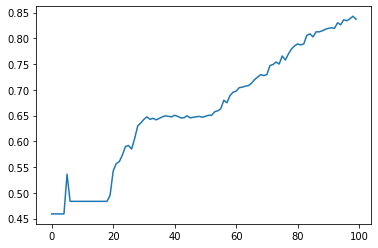

In [2]:
# Test space for networks
# Select Class Set
class_set = 0

# Initialize settings
bs = 256
weighting = 'paired'
trials = 10
epochs = 100
# trees_set = [1,2,4,8,16,32]
trees_set = [8]


classes = np.load('./results/20200511/classes.npy', allow_pickle=True)

# if class_set == 0:
#     classes = classes[0:2] # mnist fmnist
# elif class_set == 1:
#     classes = classes[2:4] # kmnist emnist
# elif class_set == 2:
#     classes = classes[4:6] # svhn usps
# else:
#     classes = classes[6].reshape(1,-1)


loss = np.zeros((len(classes), trials, len(trees_set)))
acc = np.zeros((len(classes), trials, len(trees_set)))

    
for j, (t1, t2, ds) in enumerate(classes):
    print(t1, t2, ds)
    trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds, permute=False)
    input_size = trainloaders[0].dataset.tensors[0][0].shape[0]
    for i in range(trials):
        for k, trees in enumerate(trees_set):
            print(j, i, k)
#             model = ktree_gen(ds=ds, Repeats=trees, Padded=True).cuda()
            model = simple_fcnn(input_size, 2*trees, 1).cuda()
            
#             loss_curve, acc_curve, loss[j,i,k], acc[j,i,k], model_t = train_test_ktree(model, trainloaders[i],
#                                                                                   validloaders[i], testloader, epochs = epochs, randorder=False)
            loss_curve, acc_curve, loss[j,i], acc[j,i], model_t = train_test_fc(model, trainloaders[i],
                                              validloaders[i], testloader, epochs = epochs)
            break
        break
    break

plt.plot(acc_curve)

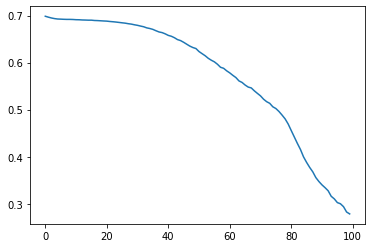

In [3]:
plt.plot(loss_curve)